# Sider+Offsides with Mol2Vec

# Implementação da Baseline

 - Nesta implementação vamos usar um modelo Mol2vec pre-treinado para criar embeddings dos compostos (Algo que esteja implementado no DeepChem). 

- Depois vamos usar os embeddings (carregados como NumpyDataset) como input para um modelo MultitaskClassifier.

In [94]:
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import Word2Vec
from gensim.models import word2vec
from rdkit import Chem
import pandas as pd
import numpy as np
from keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import deepchem as dc
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from deepchem.data.datasets import NumpyDataset
import warnings
warnings.filterwarnings('ignore')

In [95]:
"""
OFFSIDES dataset loader.
"""
from __future__ import division
from __future__ import unicode_literals

import os
import logging
import deepchem

logger = logging.getLogger(__name__)


def load_sider_offsides_for_mol2vec(featurizer='ECFP', split='index', reload=True, K=4):
  """Load SIDER OFFSIDES datasets. Does not do train/test split"""
  # Load Sider dataset
  logger.info("About to load soderoffsides dataset.")
  data_dir = deepchem.utils.get_data_dir()
  if reload:
    save_dir = os.path.join(data_dir, "sideroffsides/" + featurizer + "/" + str(split))
    print(save_dir)
    dataset_file = os.path.join("/home/mamonteiro/source-code/Project-LEI/sider+offsides/", "sider+offsides_combined.csv.gz")


  SIDER_OFFSIDES_tasks = sorted([ 'Hepatobiliary disorders',
       'Metabolism and nutrition disorders', 'Product issues', 'Eye disorders',
       'Investigations', 'Musculoskeletal and connective tissue disorders',
       'Gastrointestinal disorders', 'Social circumstances',
       'Immune system disorders', 'Reproductive system and breast disorders',
       'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
       'General disorders and administration site conditions',
       'Endocrine disorders', 'Surgical and medical procedures',
       'Vascular disorders', 'Blood and lymphatic system disorders',
       'Skin and subcutaneous tissue disorders',
       'Congenital, familial and genetic disorders',
       'Infections and infestations',
       'Respiratory, thoracic and mediastinal disorders',
       'Psychiatric disorders', 'Renal and urinary disorders',
       'Pregnancy, puerperium and perinatal conditions',
       'Ear and labyrinth disorders', 'Cardiac disorders',
       'Nervous system disorders',
       'Injury, poisoning and procedural complications'
  ])

  if reload:
    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(save_dir)
    if loaded:
      return SIDER_OFFSIDES_tasks, all_dataset, transformers

  # Featurize MUV dataset
  logger.info("About to featurize OFFSIDES dataset.")

  if featurizer == 'ECFP':
    featurizer = deepchem.feat.CircularFingerprint(size=1024)
  elif featurizer == 'GraphConv':
    featurizer = deepchem.feat.ConvMolFeaturizer()
  elif featurizer == 'Weave':
    featurizer = deepchem.feat.WeaveFeaturizer()
  elif featurizer == 'Raw':
    featurizer = deepchem.feat.RawFeaturizer()

  loader = deepchem.data.CSVLoader(
      tasks=SIDER_OFFSIDES_tasks, smiles_field="smiles", featurizer=featurizer)
  dataset = loader.featurize(dataset_file)

  # Initialize transformers
  transformers = [
      deepchem.trans.BalancingTransformer(transform_w=True, dataset=dataset)
  ]
  logger.info("About to transform data")
  for transformer in transformers:
    dataset = transformer.transform(dataset)

  if split == None:
    return OFFSIDES_tasks, (dataset, None, None), transformers

  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'scaffold': deepchem.splits.ScaffoldSplitter(),
      'task': deepchem.splits.TaskSplitter()
  }
  splitter = splitters[split]
  if split == 'task':
    fold_datasets = splitter.k_fold_split(dataset, K)
    all_dataset = fold_datasets
  else:
    train, valid, test = splitter.train_valid_test_split(dataset)
    all_dataset = (train, valid, test)
    if reload:
      deepchem.utils.save.save_dataset_to_disk(save_dir, train, valid, test,
                                               transformers)
  return SIDER_OFFSIDES_tasks, all_dataset, transformers


In [96]:
tasks, datasets, transformers = load_sider_offsides_for_mol2vec()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids
valid_smiles = valid_dataset.ids

/tmp/sideroffsides/ECFP/index
Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


In [97]:
len(train_dataset)

1352

In [98]:
train_dataset.ids

array(['CC12CCC3C(C1CCC2=O)CC=C4C3(CCC(C4)O)C', 'C[N+](C)(C)CC(CC(=O)O)O',
       'C(CC(=O)O)CN', ...,
       'COC1=C(C(=NC=C1)CS(=O)C2=NC3=C(N2)C=C(C=C3)OC(F)F)OC',
       'COC1=C(C=C(C=C1)CC2=NC=CC3=CC(=C(C=C32)OC)OC)OC',
       'C1C(C(C(C(C1N)OC2C(C(C(C(O2)CO)O)O)N)OC3C(C(C(O3)CO)OC4C(C(C(C(O4)CN)O)O)N)O)O)N'],
      dtype=object)

In [99]:
#df['smiles'][0:5]

In [100]:
# Get SMILES from file
def getSMILES(filepath):
    df = pd.read_csv(filepath)    
    #smiles = list(df['SMILES or PubChem ID'].dropna())
    smiles_df = df[['smiles']].dropna()
    # some cases have 2 SMILES per compound, which I think are isomers (by looking at the molecular drawings)
    # keeping only the first SMILE string:
    #smiles = [x.split(';')[0] for x in smiles]
    return smiles_df

In [101]:
# Generate molecules from SMILES strings
def generateEmbeddings(smiles_df, trained_model):
    smiles = list(smiles_df['smiles'])
    smiles = [x.split(';')[0] for x in smiles]
    # SMILES to Mol
    molecules = [Chem.MolFromSmiles(x) for x in smiles]
    # Load previously trained mol2vec model
    model = Word2Vec.load(trained_model)
    # Convert molecules to sentences and then to embeddings
    sentences = [mol2alt_sentence(x, 1) for x in molecules]
    vectors = [DfVec(x) for x in sentences2vec(sentences, model, unseen='UNK')]
    vec_df = pd.DataFrame(data=np.array([x.vec for x in vectors]))
    vec_df.columns = ['mol2vec_' + str(x+1) for x in vec_df.columns.values]
    vec_df.index = smiles_df.index.values
    return pd.concat([smiles_df, vec_df], axis=1)

In [102]:
def createDataset(original_data, embeddings_df, output):
    original_df = pd.read_csv(original_data)
    df = original_df.merge(embeddings_df, how='outer', on="smiles")
    df.to_csv(output, index=False)    

In [103]:
train_smiles_from_offsides=train_dataset.ids
valid_smiles_from_offsides=valid_dataset.ids
test_smiles_from_offsides=test_dataset.ids

In [104]:
type(train_smiles_from_offsides)

numpy.ndarray

In [105]:
train_smiles_from_offsides=pd.DataFrame(train_smiles_from_offsides,  columns=['smiles'])
valid_smiles_from_offsides=pd.DataFrame(valid_smiles_from_offsides,  columns=['smiles'])
test_smiles_from_offsides=pd.DataFrame(test_smiles_from_offsides,  columns=['smiles'])

In [106]:
len(train_smiles_from_offsides)

1352

In [107]:
import os
 
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)

current directory is : /home/mamonteiro/source-code/Project-LEI/sider+offsides
Directory name is : sider+offsides


In [108]:
#Estas 3 linhas deveriam ser feitas de outra maneira
#Deveriamos fazer o mesmo com o dataset completo mas neste momento vai ficar assim pelo receio que tenho de nao ter o dataset dividido como suposto

train_embeddings_generated_from_mol2vec = generateEmbeddings(train_smiles_from_offsides, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')

valid_embeddings_generated_from_mol2vec = generateEmbeddings(valid_smiles_from_offsides, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')
test_embeddings_generated_from_mol2vec = generateEmbeddings(test_smiles_from_offsides, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')

In [109]:
train_embeddings_generated_from_mol2vec.head()

,smiles,mol2vec_1,mol2vec_2,mol2vec_3,mol2vec_4,mol2vec_5,mol2vec_6,mol2vec_7,mol2vec_8,mol2vec_9,...,mol2vec_291,mol2vec_292,mol2vec_293,mol2vec_294,mol2vec_295,mol2vec_296,mol2vec_297,mol2vec_298,mol2vec_299,mol2vec_300
0,CC12CCC3C(C1CCC2=O)CC=C4C3(CCC(C4)O)C,-1.687902,-4.574107,-3.788245,0.820349,-1.165568,-7.593350,-8.685431,3.990403,0.837541,...,1.517185,14.211781,-2.282333,-1.685342,-10.677238,-8.447270,-10.454116,-1.177601,-10.021074,2.415180
1,C[N+](C)(C)CC(CC(=O)O)O,2.769547,-3.059868,-1.797269,-0.953987,4.924242,0.454827,-9.468398,1.997672,2.284252,...,-1.738315,-0.433908,6.375163,1.494671,-5.280170,-2.230168,3.010262,-5.875394,-4.850206,0.262021
2,C(CC(=O)O)CN,-0.599405,0.307458,-0.714178,-0.674214,2.840279,-0.157350,-3.893690,-0.316774,1.240166,...,-0.479649,2.350071,2.795008,2.045637,-3.803340,-0.811048,0.601341,-3.857245,-3.734070,-1.403350
3,C1C(N(C2=C(N1)NC(=NC2=O)N)C=O)CNC3=CC=C(C=C3)C...,1.644671,-4.325292,-5.132446,4.536877,2.365319,-1.383428,-16.086567,-2.104912,9.071654,...,-0.469195,12.227261,11.296147,3.872406,-12.161841,-6.847059,-4.032226,-7.607767,-16.263073,-3.654300
4,CCCCCC(C=CC1C(CC(=O)C1CC=CCCCC(=O)O)O)O,-0.658838,-3.338789,-3.176840,-0.045156,6.762016,-4.120831,-17.303051,-0.583435,3.757764,...,-7.855739,6.595695,7.846533,1.867607,-9.597700,-8.820236,-5.526588,-5.572998,-11.429805,-4.801989


In [110]:
len(train_embeddings_generated_from_mol2vec),len(valid_embeddings_generated_from_mol2vec),len(test_embeddings_generated_from_mol2vec) 

(1352, 169, 169)

In [111]:
train_embeddings_generated_from_mol2vec.iloc[0][0]

'CC12CCC3C(C1CCC2=O)CC=C4C3(CCC(C4)O)C'


# Multitask Networks On SIDER+OFFSIDES

In [112]:
import os
import deepchem as dc

The dataset that we must manipulate is thhe follwoing one: dataset

In this dataset has as columns the SMILES
                               The side efects
                               and finally the embeddings
        
We need to split this dataset in order to provide this data to multitask model

In [113]:
#dataset=dataset.drop(['smiles'], axis=1)

In [114]:
train_embeddings=train_embeddings_generated_from_mol2vec.drop(['smiles'], axis=1)
valid_embeddings=valid_embeddings_generated_from_mol2vec.drop(['smiles'], axis=1)
test_embeddings=test_embeddings_generated_from_mol2vec.drop(['smiles'], axis=1)

In [115]:
train_embeddings.head()

,mol2vec_1,mol2vec_2,mol2vec_3,mol2vec_4,mol2vec_5,mol2vec_6,mol2vec_7,mol2vec_8,mol2vec_9,mol2vec_10,...,mol2vec_291,mol2vec_292,mol2vec_293,mol2vec_294,mol2vec_295,mol2vec_296,mol2vec_297,mol2vec_298,mol2vec_299,mol2vec_300
0,-1.687902,-4.574107,-3.788245,0.820349,-1.165568,-7.593350,-8.685431,3.990403,0.837541,-1.743650,...,1.517185,14.211781,-2.282333,-1.685342,-10.677238,-8.447270,-10.454116,-1.177601,-10.021074,2.415180
1,2.769547,-3.059868,-1.797269,-0.953987,4.924242,0.454827,-9.468398,1.997672,2.284252,-0.435059,...,-1.738315,-0.433908,6.375163,1.494671,-5.280170,-2.230168,3.010262,-5.875394,-4.850206,0.262021
2,-0.599405,0.307458,-0.714178,-0.674214,2.840279,-0.157350,-3.893690,-0.316774,1.240166,-1.818650,...,-0.479649,2.350071,2.795008,2.045637,-3.803340,-0.811048,0.601341,-3.857245,-3.734070,-1.403350
3,1.644671,-4.325292,-5.132446,4.536877,2.365319,-1.383428,-16.086567,-2.104912,9.071654,2.479271,...,-0.469195,12.227261,11.296147,3.872406,-12.161841,-6.847059,-4.032226,-7.607767,-16.263073,-3.654300
4,-0.658838,-3.338789,-3.176840,-0.045156,6.762016,-4.120831,-17.303051,-0.583435,3.757764,-3.908807,...,-7.855739,6.595695,7.846533,1.867607,-9.597700,-8.820236,-5.526588,-5.572998,-11.429805,-4.801989


In [116]:
train_embeddings.isnull().any().any()

False

In [117]:
len(train_embeddings.columns)

300

In [118]:
len(train_embeddings)

1352

In [119]:
NCA1 = 100
NCA2 = 100
DROPRATE = 0.2
EP = 50
BATCH_SIZE = 128
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [120]:
# VERFICAR SE É NECESSÁRIO
from deepchem.data.datasets import NumpyDataset # import NumpyDataset

In [121]:
train_embeddings_dataset = dc.data.NumpyDataset(train_embeddings,
                                                train_dataset.y,
                                                train_dataset.w,
                                                train_dataset.ids)

In [122]:
valid_embeddings_dataset = dc.data.NumpyDataset(valid_embeddings,
                                                valid_dataset.y,
                                                valid_dataset.w,
                                                valid_dataset.ids)

In [123]:
test_embeddings_dataset = dc.data.NumpyDataset(test_embeddings,
                                                test_dataset.y,
                                                test_dataset.w,
                                                test_dataset.ids)

In [124]:
nb_epochs=[50,100, 150, 200,250,300,400,500,1000]
losses = []
loss =0

In [125]:
model = dc.models.MultitaskClassifier(n_tasks=27,
                                      n_features=300,
                                      layer_sizes=[512])

for epoch in nb_epochs :
    loss = model.fit(train_embeddings_dataset, epoch=epoch)
    print("Epoch %d loss: %f" % (epoch, loss))
    losses.append(loss)

Epoch 50 loss: 2600.783439
Epoch 100 loss: 2310.072023
Epoch 150 loss: 2282.796738
Epoch 200 loss: 2240.528351
Epoch 250 loss: 2221.412093
Epoch 300 loss: 2204.941147
Epoch 400 loss: 2169.904631
Epoch 500 loss: 2148.496690
Epoch 1000 loss: 2132.555502


<module 'matplotlib.pyplot' from '/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/matplotlib/pyplot.py'>

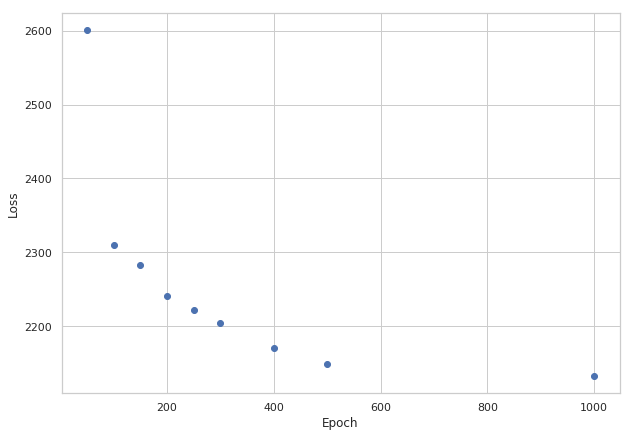

In [126]:
import matplotlib.pyplot as plot

plot.figure(figsize=(10,7))
plot.ylabel("Loss")
plot.xlabel("Epoch")
x = nb_epochs
y = losses
plot.scatter(x, y)
plot

In [127]:
import numpy as np
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")
train_score = model.evaluate(train_embeddings_dataset, [metric], transformers)
print('Training set ROC AUC:', train_score)

computed_metrics: [0.7457833696705427, 0.7458553415789071, 0.6940381653540726, 0.7803914498869362, 0.7885882389468455, 0.6904071326660873, 0.7098423262462032, 0.7106237296603722, 0.7521203155818541, 0.736236597488763, 0.6944780383785916, 0.6981741118295184, 0.666773097826087, 0.7503163536213184, 0.7618997119664833, 0.6912450902832715, 0.7283720361226034, 0.8219860974867234, 0.889950332452135, 0.7268887817809374, 0.7343201101735466, 0.7195251992367269, 0.7402148571833151, 0.6970249368686869, 0.7993485580442101, 0.6782806513409962, 0.7441545076806524]
Training set ROC AUC: {'mean-roc_auc_score': 0.7369199681243108}


In [128]:
valid_score = model.evaluate(valid_embeddings_dataset, [metric], transformers)
print('Validation set ROC AUC:', valid_score)

computed_metrics: [0.6332279390629492, 0.5473195567535192, 0.46140939597315433, 0.5476334036780224, 0.4549910873440285, 0.5123249299719888, 0.6413110698824984, 0.39192982456140346, 0.6150182123844214, 0.5767375886524824, 0.6068155784650631, 0.47780938833570413, 0.5108471074380165, 0.6057416267942584, 0.5860879563092842, 0.5788770053475936, 0.6042053184910328, 0.6793478260869565, 0.9523809523809523, 0.5292758089368259, 0.5823310423825888, 0.5636952044719035, 0.5275229357798166, 0.5952906548933039, 0.5652173913043479, 0.36037735849056607, 0.5258373205741627]
Validation set ROC AUC: {'mean-roc_auc_score': 0.5642060549906239}


In [129]:
test_score = model.evaluate(test_embeddings_dataset, [metric], transformers)
print('Validation set ROC AUC:', test_score)

computed_metrics: [0.49152173913043473, 0.4516129032258065, 0.5626934984520124, 0.5676763242610476, 0.5963888888888889, 0.4315250911129801, 0.558682855040471, 0.4431578947368422, 0.7164668949771691, 0.6001610305958132, 0.6007177033492823, 0.5334289496910856, 0.541564039408867, 0.5804315476190476, 0.49597423510466987, 0.49161821705426356, 0.4980684326710817, 0.5584905660377358, 0.592814371257485, 0.5790178571428573, 0.5748890532544378, 0.5616370808678501, 0.4923264736658528, 0.36033353186420486, 0.4974025974025974, 0.4700503355704698, 0.5051971326164875]
Validation set ROC AUC: {'mean-roc_auc_score': 0.5316240461111016}



# Valores da Baseline ....

[(0, 0.5582052484166566)]

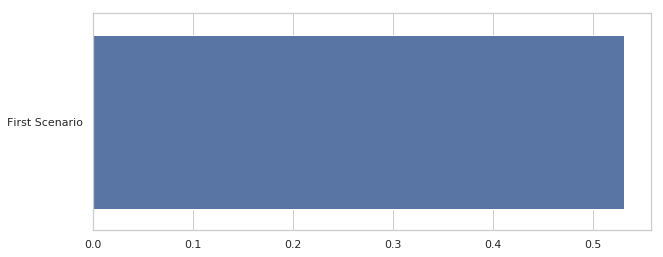

In [130]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,4)})
sns.set(style="whitegrid")
ax = sns.barplot(x=[test_score['mean-roc_auc_score']],
                 y=['First Scenario'])
ax.set(xlim=(0, None))

# # Valores com hyperparameters

In [131]:
sider_offsides_tasks = sorted([ 'Hepatobiliary disorders',
   'Metabolism and nutrition disorders', 'Product issues', 'Eye disorders',
   'Investigations', 'Musculoskeletal and connective tissue disorders',
   'Gastrointestinal disorders', 'Social circumstances',
   'Immune system disorders', 'Reproductive system and breast disorders',
   'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
   'General disorders and administration site conditions',
   'Endocrine disorders', 'Surgical and medical procedures',
   'Vascular disorders', 'Blood and lymphatic system disorders',
   'Skin and subcutaneous tissue disorders',
   'Congenital, familial and genetic disorders',
   'Infections and infestations',
   'Respiratory, thoracic and mediastinal disorders',
   'Psychiatric disorders', 'Renal and urinary disorders',
   'Pregnancy, puerperium and perinatal conditions',
   'Ear and labyrinth disorders', 'Cardiac disorders',
   'Nervous system disorders',
   'Injury, poisoning and procedural complications'
])


In [132]:
params_dict = {"activation": ["relu","sigmoid","tanh"],
               "optimizer": ['RMSprop','adam'],
               "momentum": [.9],
               "dropouts": [.5,0.2],
               "nb_layers": [512],
               "penalty": [0.]
              }

n_features = train_dataset.get_data_shape()[0]

def model_builder(model_params, model_dir):
    model = dc.models.MultitaskClassifier(
    len(sider_offsides_tasks), n_features, **model_params)
    return model

In [133]:
train_dataset.get_data_shape()[0]

1024

In [134]:
len(train_dataset)

1352

In [135]:

metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, [], metric)

Fitting model 1/12
hyperparameters: {'activation': 'relu', 'optimizer': 'RMSprop', 'momentum': 0.9, 'dropouts': 0.5, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.5227076746191435, 0.5768194070080863, 0.6345637583892617, 0.479951763641845, 0.5374331550802138, 0.5176470588235293, 0.5893630179344465, 0.4392982456140351, 0.5383861025497338, 0.5682269503546099, 0.5667955326460481, 0.5093883357041251, 0.5432162534435261, 0.5733652312599682, 0.5487208968094279, 0.6559714795008913, 0.531230674087817, 0.75, 0.10119047619047618, 0.5087827426810478, 0.5486827033218786, 0.550456016475434, 0.5093272171253823, 0.5187637969094923, 0.4997022036926742, 0.48930817610062893, 0.5676236044657097]
Model 1/12, Metric mean-roc_auc_score, Validation set 0: 0.532479
	best_validation_score so far: 0.532479
Fitting model 2/12
hyperparameters: {'activation': 'relu', 'optimizer': 'RMSprop', 'momentum': 0.9, 'dropouts': 0.2, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.5240011497556769, 0.5426774

computed_metrics: [0.5245760275941362, 0.5616951182988918, 0.5949664429530201, 0.49261380765752183, 0.5267379679144386, 0.5343137254901961, 0.543908472479901, 0.45298245614035093, 0.5257775287195293, 0.5747517730496454, 0.5472508591065293, 0.5115220483641536, 0.5232438016528925, 0.5690590111642744, 0.529893647599885, 0.6753565062388591, 0.5080395794681509, 0.7344720496894409, 0.0892857142857143, 0.49984591679506934, 0.5657216494845361, 0.5532509561635774, 0.4969418960244648, 0.5312729948491538, 0.5250148898153664, 0.5333333333333333, 0.5944178628389154]
Model 11/12, Metric mean-roc_auc_score, Validation set 10: 0.530379
	best_validation_score so far: 0.536127
Fitting model 12/12
hyperparameters: {'activation': 'tanh', 'optimizer': 'adam', 'momentum': 0.9, 'dropouts': 0.2, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.5054613394653635, 0.5616951182988918, 0.6446308724832215, 0.485378353934278, 0.5381016042780749, 0.5260504201680671, 0.5590599876314163, 0.45122807017543853, 0.51

In [136]:
best_dnn

MultitaskClassifier(activation_fns=None, bias_init_consts=None, dropouts=None,
                    layer_sizes=None, n_classes=2, n_features=1024, n_tasks=27,
                    weight_decay_penalty=None, weight_decay_penalty_type=None,
                    weight_init_stddevs=None)

In [137]:
best_hyperparams

('sigmoid', 'RMSprop', 0.9, 0.5, 512, 0.0)

In [138]:
obj=best_dnn.fit(train_dataset,**params_dict)

In [139]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

In [140]:
train_scores = best_dnn.evaluate(train_dataset, [metric], transformers)
print(train_scores)

computed_metrics: [0.9439649951550387, 0.9312180812090591, 0.9615979784960331, 0.9742468351049622, 0.9870653253849975, 0.9235576974651091, 0.8940866758978023, 0.8982672283602258, 0.9553412933220626, 0.9220092727828539, 0.893877312749614, 0.8991015276237944, 0.864002490942029, 0.929601325514781, 0.9233150039277298, 0.9329183495024358, 0.9011288313537078, 0.9956744917633529, 0.9992589922294319, 0.9298924903937557, 0.9307826523347688, 0.94667350833026, 0.9064763118501437, 0.8810808982683982, 0.9926804274630362, 0.9565917798676421, 0.9243789932023447]
{'mean-roc_auc_score': 0.9332885470553841}


In [141]:
valid_scores = best_dnn.evaluate(valid_dataset, [metric], transformers)
print(valid_scores)

computed_metrics: [0.4670882437482035, 0.5444743935309972, 0.6540268456375838, 0.49713596623454925, 0.5392156862745097, 0.5366946778711484, 0.5457637600494742, 0.4782456140350877, 0.5091061922107032, 0.5487943262411348, 0.5230526918671248, 0.5287339971550498, 0.5304752066115702, 0.5470494417862839, 0.5587812589824663, 0.6535204991087344, 0.5451453308596166, 0.7290372670807455, 0.029761904761904764, 0.5163328197226502, 0.5277777777777778, 0.5286849073256841, 0.5062691131498471, 0.5272259013980869, 0.4928528886241811, 0.5672955974842767, 0.5971291866028707]
{'mean-roc_auc_score': 0.5270248702271209}


In [142]:
test_scores_v1 = best_dnn.evaluate(test_dataset, [metric], transformers)
print(test_scores_v1)

computed_metrics: [0.5627536231884058, 0.5123605667772083, 0.4311145510835913, 0.587211003804507, 0.5572222222222223, 0.4879450518643118, 0.5566593083149375, 0.4870175438596491, 0.579480593607306, 0.5144927536231885, 0.5432216905901117, 0.5083848190644307, 0.5724137931034483, 0.549404761904762, 0.48888888888888893, 0.5901162790697674, 0.45327446651949965, 0.4, 0.1526946107784431, 0.5266369047619048, 0.5494082840236687, 0.5459284305438152, 0.5008719916288804, 0.5696843359142346, 0.3588744588744589, 0.47919463087248326, 0.49677419354838714]
{'mean-roc_auc_score': 0.5022973984604634}


[(0, 0.5582052484166566)]

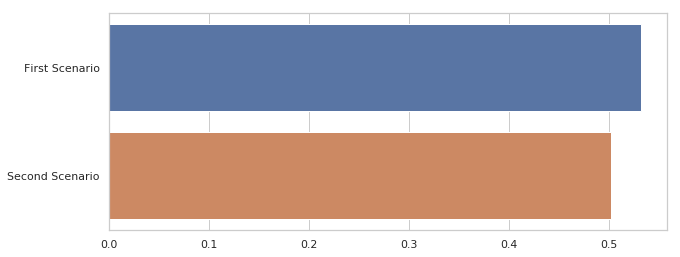

In [143]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,4)})
sns.set(style="whitegrid")
ax = sns.barplot(x=[test_score['mean-roc_auc_score'],test_scores_v1['mean-roc_auc_score']],
                 y=['First Scenario','Second Scenario'])
ax.set(xlim=(0, None))